In [5]:
import requests
import numpy as np
import pandas as pd
import time
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('final_dataset', sep = ',')
df = df.drop('Unnamed: 0', axis = 1)

##Причешем данные

Изначально данная исследовательская работа выглядело как что-то веселое и не затейливое. Мы просто выделели интересные признаки, которые можно нарыть на Хэд хантере и хорошо спарсить. Как же мы ошибались... Из-за огромного количества костылей в коде сайта спаршенный датасет получился неимоверно сырым, и сейчас мы это будем потихоньку фиксить.

1. Избавимся от колонки ВУЗ. До того как начать парсить данные, этот признак выглядел достаточно важныы и интересным для анализа, однако уже после выяснилось, что, во-первых, ВУЗов слишком много, чтобы включить их в список категориальных переменных. Во-вторых, данная графа на хэд хантере заполняется пользователями вручную, что несет за собой полнейший хаос на болльшой выборке. Удаляем!



In [451]:
df = df.drop('вуз', axis = 1)

2. Теперь нужно позаботиться о непрерывных признаках, которые спарсились как обычные нечисловые объекты

2.1. Начнем с исправления колонок возраст и опыт, потому что они имеют одинаковое оформление. Взяв срез до 2 символа (включительно) мы получим количество лет возможно с пробелом.

In [452]:
df[['возраст', 'опыт работы']]= df[['возраст', 'опыт работы']].applymap(lambda x: float(str(x)[:2].strip()), na_action= 'ignore')

/var/folders/6p/80ct6mvj5cv9c6fyfy3vdvfc0000gn/T/ipykernel_14734/2278824240.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['возраст', 'опыт работы']]= df[['возраст', 'опыт работы']].applymap(lambda x: float(str(x)[:2].strip()), na_action= 'ignore')


  2.2. Теперь поправим ЗП. Для этого мало того, что нужно избавиться от дурацкой надписи "на руки" (на разных языках), дак еще и привести все к одной валюте (слава богу, на hh есть только доллары, рубли и евро). Возьмем по нынешнем меркам: 91.63 ₽ за один доллар и 98.73 ₽ за одно евро. Для этого напишем универсальную функцию

In [453]:
def blagodat(x):
  if '€' in x:
    return int(x[:-9].replace('\u2009', ''))*98.73
  elif '₽' in x:
    return int(x[:-9].replace('\u2009', ''))
  else:
    return int(x[:-9].replace('\u2009', ''))*91.63

In [454]:
df['желаемая з/п'] = df['желаемая з/п'].map(blagodat)

In [455]:
df

,опыт работы,регион,пол,возраст,образование,язык,занятость,желаемая з/п,Последнее место работы
0,24.0,Санкт-Петербург,Мужчина,45.0,Неоконченное высшее образование,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,100000.00,Январь 2000 — по настоящее время24 года 5 месяцев
1,26.0,Самара,Мужчина,49.0,Высшее образование,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,157869.27,Январь 2006 — по настоящее время18 лет 5 месяцев
2,2.0,Екатеринбург,Мужчина,23.0,Неоконченное высшее образование,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,200000.00,Июль 2021 — по настоящее время2 года 11 месяцев
3,25.0,Tomsk,Male,56.0,Higher education,Russian — Native English — B1 — Intermediate,"Employment: full time, part time, project work",50000.00,September 1998 — currently25 years 9 months
4,12.0,Пермь,Мужчина,38.0,Высшее образование,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,90000.00,Сентябрь 2015 — по настоящее время8 лет 9 месяцев
...,...,...,...,...,...,...,...,...,...
995,4.0,Макеевка,Мужчина,25.0,Высшее образование (Бакалавр),Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,30000.00,Март 2020 — по настоящее время4 года 3 месяца
996,NaN,Москва,Мужчина,30.0,Высшее образование,Русский — Родной Английский — C1 — Продвинутый,"Занятость: полная занятость, частичная занятость",95000.00,2017
997,13.0,Москва,Мужчина,33.0,Высшее образование,Русский — Родной Английский — A1 — Начальный,Занятость: полная занятость,120000.00,Сентябрь 2020 — по настоящее время3 года 9 мес...
998,19.0,Москва,Мужчина,56.0,Высшее образование,Русский — Родной Английский — A2 — Элементарный,"Занятость: полная занятость, частичная занятос...",280000.00,Июль 2016 — по настоящее время7 лет 11 месяцев


3. Подходит время и до категориальных признаков. Напомню, что на Хэд хантере на фронт энде сидит что-то похожее на высшего примата, и некоторые наблюдения на английском

3.1 Начнем с мужчин и женщин, тут будет все совсем просто

In [456]:
df['пол'] = df['пол'].replace({'Male': 'Мужчина', 'Female': 'Женщина'})

In [457]:
df = pd.get_dummies(df, columns = ['пол'], dtype = int, drop_first = True)

3.2. Далее плавно переходим к образованию. Здесь все тоже достаточно просто, ведь высшее образование может быть или не быть, без разницы, что там айтишники понапридумывали в своих анкетах

In [458]:
df['образование'] = ((df['образование'] == 'Высшее образование') | (df['образование'] == 'Higher education'))

In [459]:
df['образование'] = df['образование'].map(float)
df

,опыт работы,регион,возраст,образование,язык,занятость,желаемая з/п,Последнее место работы,пол_Мужчина,пол_Пол не указан
0,24.0,Санкт-Петербург,45.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,100000.00,Январь 2000 — по настоящее время24 года 5 месяцев,1,0
1,26.0,Самара,49.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,157869.27,Январь 2006 — по настоящее время18 лет 5 месяцев,1,0
2,2.0,Екатеринбург,23.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,200000.00,Июль 2021 — по настоящее время2 года 11 месяцев,1,0
3,25.0,Tomsk,56.0,1.0,Russian — Native English — B1 — Intermediate,"Employment: full time, part time, project work",50000.00,September 1998 — currently25 years 9 months,1,0
4,12.0,Пермь,38.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,90000.00,Сентябрь 2015 — по настоящее время8 лет 9 месяцев,1,0
...,...,...,...,...,...,...,...,...,...,...
995,4.0,Макеевка,25.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,30000.00,Март 2020 — по настоящее время4 года 3 месяца,1,0
996,NaN,Москва,30.0,1.0,Русский — Родной Английский — C1 — Продвинутый,"Занятость: полная занятость, частичная занятость",95000.00,2017,1,0
997,13.0,Москва,33.0,1.0,Русский — Родной Английский — A1 — Начальный,Занятость: полная занятость,120000.00,Сентябрь 2020 — по настоящее время3 года 9 мес...,1,0
998,19.0,Москва,56.0,1.0,Русский — Родной Английский — A2 — Элементарный,"Занятость: полная занятость, частичная занятос...",280000.00,Июль 2016 — по настоящее время7 лет 11 месяцев,1,0


3.3. Теперь поговорим про последнее место работы. Довольно интересная переменная, она хранит в себе довольно большой объем информации, однако нам по большей части важно лишь одно -- работает ли человек в данный момент на этой работе или нет, поэтому опять применим бинарную классификацию

In [460]:
df['Последнее место работы'] = df['Последнее место работы'].map(lambda x: ('время' in x) or ('currently' in x), na_action='ignore')
df['Последнее место работы'] = df['Последнее место работы'].map(int, na_action='ignore')

In [461]:
df

,опыт работы,регион,возраст,образование,язык,занятость,желаемая з/п,Последнее место работы,пол_Мужчина,пол_Пол не указан
0,24.0,Санкт-Петербург,45.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,100000.00,1.0,1,0
1,26.0,Самара,49.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,157869.27,1.0,1,0
2,2.0,Екатеринбург,23.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,200000.00,1.0,1,0
3,25.0,Tomsk,56.0,1.0,Russian — Native English — B1 — Intermediate,"Employment: full time, part time, project work",50000.00,1.0,1,0
4,12.0,Пермь,38.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,Занятость: полная занятость,90000.00,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,4.0,Макеевка,25.0,0.0,Русский — Родной Английский — B1 — Средний,Занятость: полная занятость,30000.00,1.0,1,0
996,NaN,Москва,30.0,1.0,Русский — Родной Английский — C1 — Продвинутый,"Занятость: полная занятость, частичная занятость",95000.00,0.0,1,0
997,13.0,Москва,33.0,1.0,Русский — Родной Английский — A1 — Начальный,Занятость: полная занятость,120000.00,1.0,1,0
998,19.0,Москва,56.0,1.0,Русский — Родной Английский — A2 — Элементарный,"Занятость: полная занятость, частичная занятос...",280000.00,1.0,1,0


3.4. Нужно что-то сделать с занятостью. Так как в данном случае бинарная классификация просто не уместна, ведь один человек может сочетать в себе не только одно значение переменной. С другой стороны, для дальнейшего анализа, сочетание желаемой занятости можно представить в виде вектора, однако такой вариант нам тоже не очень подходит. Поэтому нами было решено придти к новому показателю, который отображает гибкость работника. Таким образом, если айтишник готов работать частино, мы ему даем 0.75 балл гибкости, над проектом -- 1, а за фулл дэй целых 1.5. После сложения всех очков, имеем итоговый показатель гибкости потенциального сотрудника.

Но для начала все опять нужно перевести с тарабарского на православный

In [462]:
eng_to_rus = {'Employment': 'Занятость', 'full': 'полная', 'time': 'занятость', 'part': 'частичная', 'project': 'проектная', 'work': 'работа'}
def pravoslavie(el):
  for key in eng_to_rus:
    if key in str(el):
      el = str(el).replace(key, eng_to_rus[key])
  return el
def flex_score(el):
  score = 0
  if 'полная' in el:
    score += 1.5
  if 'частичная' in el:
    score += 0.75
  if 'проектная' in el:
    score += 1
  return score

In [463]:
df['занятость'] = df['занятость'].map(pravoslavie, na_action = 'ignore')
df['занятость'] = df['занятость'].map(flex_score, na_action = 'ignore')
df

,опыт работы,регион,возраст,образование,язык,занятость,желаемая з/п,Последнее место работы,пол_Мужчина,пол_Пол не указан
0,24.0,Санкт-Петербург,45.0,0.0,Русский — Родной Английский — B1 — Средний,1.50,100000.00,1.0,1,0
1,26.0,Самара,49.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,1.50,157869.27,1.0,1,0
2,2.0,Екатеринбург,23.0,0.0,Русский — Родной Английский — B1 — Средний,1.50,200000.00,1.0,1,0
3,25.0,Tomsk,56.0,1.0,Russian — Native English — B1 — Intermediate,3.25,50000.00,1.0,1,0
4,12.0,Пермь,38.0,1.0,Русский — Родной Английский — B2 — Средне-прод...,1.50,90000.00,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,4.0,Макеевка,25.0,0.0,Русский — Родной Английский — B1 — Средний,1.50,30000.00,1.0,1,0
996,NaN,Москва,30.0,1.0,Русский — Родной Английский — C1 — Продвинутый,2.25,95000.00,0.0,1,0
997,13.0,Москва,33.0,1.0,Русский — Родной Английский — A1 — Начальный,1.50,120000.00,1.0,1,0
998,19.0,Москва,56.0,1.0,Русский — Родной Английский — A2 — Элементарный,3.25,280000.00,1.0,1,0


3.5. Предпоследняя часть -- языки. Так как парсили мы hh.ru, то представлений что делать с этой колонкой у меня немного, поэтому на данном этапе мы от нее избавимся.

К слову, просим взглянуть

In [464]:
df['язык'].unique()

array(['Русский — Родной Английский — B1 — Средний',
       'Русский — Родной Английский — B2 — Средне-продвинутый Немецкий — B2 — Средне-продвинутый',
       'Russian — Native English — B1 — Intermediate',
       'Русский — Родной Английский — B2 — Средне-продвинутый',
       'Русский — Родной Английский — A1 — Начальный',
       'Английский — C2 — В совершенстве', 'Русский — Родной',
       'Русский — Родной Английский — A1 — Начальный Немецкий — A1 — Начальный',
       'Russian — Native English — B2 — Upper Intermediate',
       'Английский — B2 — Средне-продвинутый',
       'Русский — Родной Английский — B2 — Средне-продвинутый Немецкий — A1 — Начальный',
       'Русский — Родной Английский — A1 — Начальный Корейский — A1 — Начальный Японский — A1 — Начальный',
       'Русский — Родной Английский — C1 — Продвинутый',
       'Русский — Родной Английский — C2 — В совершенстве',
       'Русский — Родной Английский — C1 — Продвинутый Украинский — C2 — В совершенстве',
       'Русский —

In [465]:
df = df.drop('язык', axis = 1)

Что-то из головы вылетело

In [466]:
df = df.drop('пол_Пол не указан', axis = 1)
df

,опыт работы,регион,возраст,образование,занятость,желаемая з/п,Последнее место работы,пол_Мужчина
0,24.0,Санкт-Петербург,45.0,0.0,1.50,100000.00,1.0,1
1,26.0,Самара,49.0,1.0,1.50,157869.27,1.0,1
2,2.0,Екатеринбург,23.0,0.0,1.50,200000.00,1.0,1
3,25.0,Tomsk,56.0,1.0,3.25,50000.00,1.0,1
4,12.0,Пермь,38.0,1.0,1.50,90000.00,1.0,1
...,...,...,...,...,...,...,...,...
995,4.0,Макеевка,25.0,0.0,1.50,30000.00,1.0,1
996,NaN,Москва,30.0,1.0,2.25,95000.00,0.0,1
997,13.0,Москва,33.0,1.0,1.50,120000.00,1.0,1
998,19.0,Москва,56.0,1.0,3.25,280000.00,1.0,1


3.6. Надо бы города тоже перевести

In [467]:
a = sorted(df['регион'].unique())
eng_city = a[:15]
rus_city = ['Донецк',
'Краснодар',
 'Красноярск',
 'Москва',
 'Находка',
 'Нальчик',
 'Новосибирск',
 'Омск',
 'Ростов-на-Дону',
 'Рязань',
 'Санкт-Петербург',
 'Самара',
 'Таганрог',
 'Томск',
 'Владикавказ']
rus_eng_city_dict = {eng_city[i]: rus_city[i] for i in range(len(eng_city))}
df['регион'] = df['регион'].replace(rus_eng_city_dict)

##EDA

Наконец почти все данные причесаны, теперь можно смотреть на них под разным углом

Начнем с самого просто: посмотрим на пропуски и заполним их

In [468]:
df.isnull().sum()

опыт работы               91
регион                     0
возраст                   29
образование                0
занятость                  0
желаемая з/п               0
Последнее место работы    18
пол_Мужчина                0
dtype: int64

Самым легким будет заменить пропуски в столбце `"Последнее место работы"`. Так как данный столбец мы использовали как флаг того, работает ли сейчас человек или нет, просто заменим все пропуски на 0, потому что, если про последнюю работу ничего не сказано, значит будем считать, что айтишник не работает

In [469]:
df['Последнее место работы'] = df['Последнее место работы'].fillna(0)

Пропуски в столбцах `'возраст'` и `'опыт работы'` заполним медианой (ну типа почему бы и нет)

In [470]:
df['возраст'] = df['возраст'].fillna(df['возраст'].median())
df['опыт работы'] = df['опыт работы'].fillna(df['опыт работы'].median())

In [471]:
df.isnull().sum()

опыт работы               0
регион                    0
возраст                   0
образование               0
занятость                 0
желаемая з/п              0
Последнее место работы    0
пол_Мужчина               0
dtype: int64

Теперь, когда все пропуски были заполнены, можем посмотреть на распределения данных. Начнем с распределения для ключевой переменной -- `'желаемая з/п'`

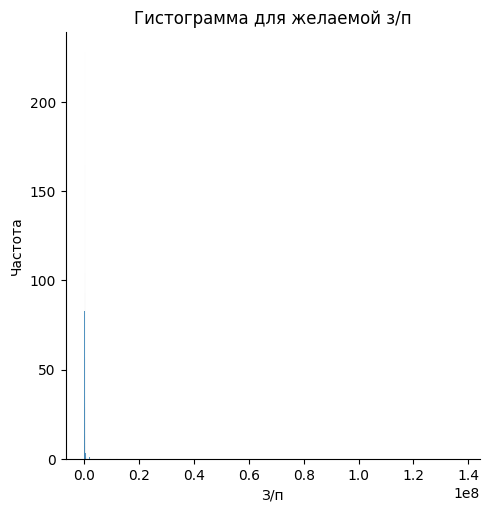

In [472]:
sns.displot(data=df['желаемая з/п'])
plt.title('Гистограмма для желаемой з/п')
plt.xlabel('З/п')
plt.ylabel('Частота')
plt.show()

Как видно на гистограмме, данные имеют достаточно большое количество выбросов, причем довольно существенных настолько, что гистограмма попросту ничего не отображает. Поэтому предврачительно, чтобы хотя бы просто пощупать данные, удалим 8 наибольших значений по з/п. В принципе это даже не портит общую структуру данных, ведь некоторые челы просто по приколу ставили себе желаемую з/п в 1 000 000 000+.

In [473]:
df = df.loc[df['желаемая з/п'] < min(df['желаемая з/п'].nlargest(8))]

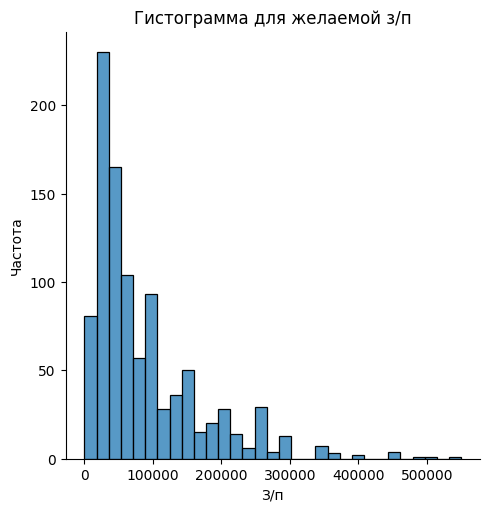

In [474]:
sns.displot(data=df['желаемая з/п'])
plt.title('Гистограмма для желаемой з/п')
plt.xlabel('З/п')
plt.ylabel('Частота')
plt.show()

После первой наивной обработки, данные стали выглядеть гораздо лучше и теперь мы уже можем посмотреть и пощупать чуть лучше наши данные. Как видно на рисунке присутствуют неадекватные хвосты, скорее всего это и есть выбросы. Чтобы ответить точно построим ящик с усами.

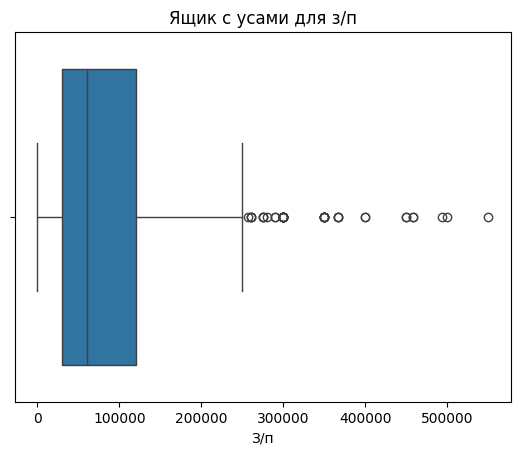

In [475]:
sns.boxplot(data=df, x = 'желаемая з/п')
plt.title('Ящик с усами для з/п')
plt.xlabel('З/п')
plt.show()

Данная диаграмма показывает нам, что выбросов действительно довольно много и все они лежат примерно после 250 000. Так как скорре всего это люди, которые ставят такие зарплаты "рофла ради", или гипер зажравшиеся сеньоры, которые уже не ищут работу на хэд хантере, просто выкинем из выборки все выбросы.

In [476]:
Q1 = df['желаемая з/п'].quantile(0.25)
Q3 = df['желаемая з/п'].quantile(0.75)
IQR = Q3 - Q1
max_must = Q3 + 1.5*IQR
min_must = Q1 - 1.5*IQR
df = df[(df['желаемая з/п'] >= min_must) & (df['желаемая з/п'] <= max_must)]
df

,опыт работы,регион,возраст,образование,занятость,желаемая з/п,Последнее место работы,пол_Мужчина
0,24.0,Санкт-Петербург,45.0,0.0,1.50,100000.00,1.0,1
1,26.0,Самара,49.0,1.0,1.50,157869.27,1.0,1
2,2.0,Екатеринбург,23.0,0.0,1.50,200000.00,1.0,1
3,25.0,Томск,56.0,1.0,3.25,50000.00,1.0,1
4,12.0,Пермь,38.0,1.0,1.50,90000.00,1.0,1
...,...,...,...,...,...,...,...,...
994,10.0,Санкт-Петербург,39.0,1.0,1.50,30000.00,0.0,1
995,4.0,Макеевка,25.0,0.0,1.50,30000.00,1.0,1
996,10.0,Москва,30.0,1.0,2.25,95000.00,0.0,1
997,13.0,Москва,33.0,1.0,1.50,120000.00,1.0,1


Небольшие выводы:
1) Абсолютное большинство готово работать за грошики (около 30 тыс. рублей)
2) Гистограмма показывает резкое увеличение количества людей, после снижения зарплаты. Сначал, при увеличении уровня з/п частота резко снижается, а потом после очередного увеличения резко возрастает, и это не разовое явление. Как вариант это может объясняться переходом между категориями (джун-мидл-сеньор).

Теперь поисследуем непрерывные признаки, для этого сначла посмотрим их распределения

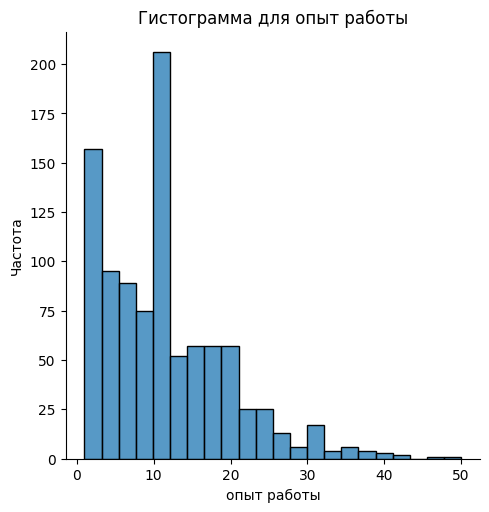

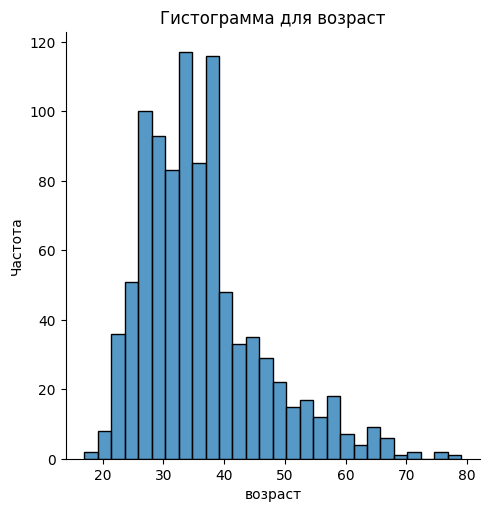

In [477]:
for el in ['опыт работы', 'возраст']:
  sns.displot(data=df[el])
  plt.title('Гистограмма для ' + el)
  plt.xlabel(el)
  plt.ylabel('Частота')
  plt.show()

Как видно из вышестоячих графиков, здесь мы тоже имеем дело с выбросами. Можно конечно закидать нас всяким вонючим, но в айтишников 70+ c опытом работы 40+ ну очень слабо верится, скорее всего мы снова имеем дело с прЕколистами, ну либо исключительными машинами, которые портят всю статистику. Однако перед тем, как с ними попрощаться, посмотрим на ящики с усами.

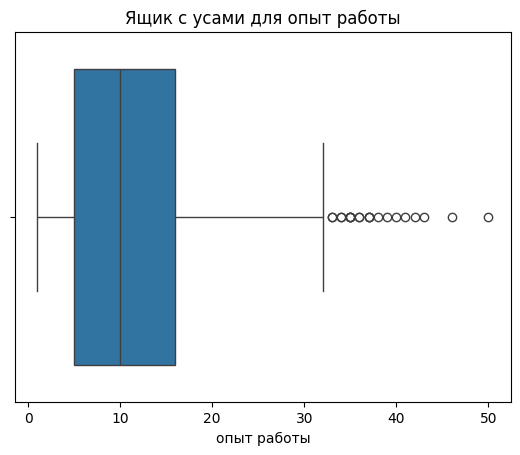

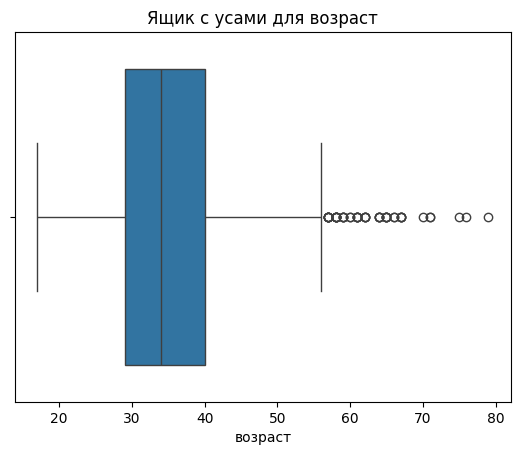

In [478]:
for el in ['опыт работы', 'возраст']:
  sns.boxplot(data=df, x = el)
  plt.title('Ящик с усами для ' + el)
  plt.xlabel(el)
  plt.show()

Ну чтд собсна. Нещадно выпиливаем выбросы!

In [479]:
for el in ['опыт работы', 'возраст']:
    Q1 = df3[el].quantile(0.25)
    Q3 = df3[el].quantile(0.75)
    IQR = Q3 - Q1
    max_must = Q3 + 1.5*IQR
    min_must = Q1 - 1.5*IQR
    df = df[(df[el] >= min_must) & (df[el] <= max_must)]
df

,опыт работы,регион,возраст,образование,занятость,желаемая з/п,Последнее место работы,пол_Мужчина
0,24.0,Санкт-Петербург,45.0,0.0,1.50,100000.00,1.0,1
1,26.0,Самара,49.0,1.0,1.50,157869.27,1.0,1
2,2.0,Екатеринбург,23.0,0.0,1.50,200000.00,1.0,1
4,12.0,Пермь,38.0,1.0,1.50,90000.00,1.0,1
5,10.0,Балашов,27.0,0.0,0.75,15000.00,1.0,0
...,...,...,...,...,...,...,...,...
994,10.0,Санкт-Петербург,39.0,1.0,1.50,30000.00,0.0,1
995,4.0,Макеевка,25.0,0.0,1.50,30000.00,1.0,1
996,10.0,Москва,30.0,1.0,2.25,95000.00,0.0,1
997,13.0,Москва,33.0,1.0,1.50,120000.00,1.0,1


Пришло время выводов от мудрого царя:
1) Большинство айтишников начинают осознавать себя таковыми после примерно 22 лет, большая часть при этом 30+
2) Среди айтишников также есть и пожилые люди и не сказать, что их прям очень мало
3) Большая часть наших подопечных имеют опыт окол 10 лет, что очень даже ожидаемо, ведь это направление начало активно разваиваться в России как раз тогда
4) Однако из-за того, что очередной бум зарплат и популярности данной отрасли произошел относительно недавно, на рынке также присутствует достаточно много малоопытных людей (год - два)

Пришло время посмотреть на категориальные переменные. Однако еще с момента причесывания данных у нас остался костыль в виде `'регион'`. И вроде как все очевидно применяем OHE-кодирование, но вот беда, иметь дело с 192 переменными(см. ниже) не очень хочется. Поэтому прикинем, каких городов в нашей выборке сколько.

In [480]:
print('Количество различных регионов:', len(df3['регион'].unique()))

Количество различных регионов: 3


In [481]:
md = {city: df['регион'][df['регион'] == city].shape[0] for city in df['регион'].unique()}
dict(sorted(md.items(), key = lambda x: x[1])[::-1]) 

{'Москва': 196,
 'Санкт-Петербург': 82,
 'Краснодар': 27,
 'Новосибирск': 23,
 'Нижний Новгород': 19,
 'Казань': 18,
 'Уфа': 18,
 'Екатеринбург': 18,
 'Иркутск': 12,
 'Ижевск': 12,
 'Красноярск': 12,
 'Самара': 12,
 'Ростов-на-Дону': 11,
 'Тюмень': 10,
 'Пермь': 10,
 'Ярославль': 9,
 'Белгород': 9,
 'Тула': 8,
 'Саратов': 8,
 'Ставрополь': 8,
 'Томск': 8,
 'Стерлитамак': 7,
 'Королев': 7,
 'Калининград': 6,
 'Киров (Кировская область)': 6,
 'Волгоград': 6,
 'Астрахань': 6,
 'Липецк': 6,
 'Челябинск': 6,
 'Кемерово': 6,
 'Омск': 5,
 'Воронеж': 5,
 'Мурманск': 5,
 'Тверь': 5,
 'Чебоксары': 5,
 'Барнаул': 5,
 'Тамбов': 5,
 'Владивосток': 5,
 'Архангельск': 5,
 'Тольятти': 5,
 'Хабаровск': 4,
 'Оренбург': 4,
 'Севастополь': 4,
 'Великий Новгород': 4,
 'Сыктывкар': 4,
 'Сургут': 4,
 'Орел': 4,
 'Сочи': 4,
 'Владимир': 4,
 'Вологда': 4,
 'Калуга': 3,
 'Обнинск': 3,
 'Курган': 3,
 'Ульяновск': 3,
 'Симферополь': 3,
 'Петрозаводск': 3,
 'Череповец': 3,
 'Луганск': 3,
 'Новороссийск': 3,
 'Арма

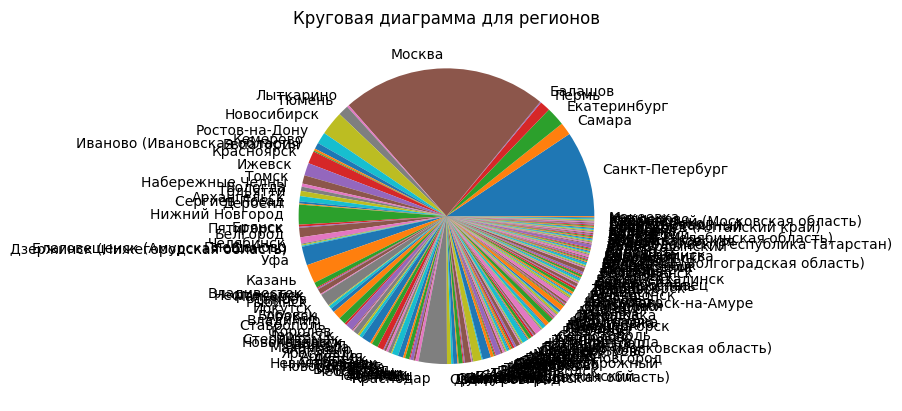

In [482]:
plt.pie(md.values(), labels = list(md.keys()))
plt.title('Круговая диаграмма для регионов')
plt.show()


Ну и жуть конечно у нас получилась. Надо что-то делать...

Как можно заметить в отсортированном по значениям словаре (`'md'`) и на этой "прекрасной" круговой диаграмме, наибольшие категории -- это мск(199) и спб(82), а остальных ну сильно меньше. Раз так, давайте выделим три категории: Мск, СпБ и другое, а потом уже и OHE не грех применить будет.

In [483]:
def russia_be_like(gorod):
    if gorod != 'Москва' and gorod != 'Санкт-Петербург':
        gorod = 'Другое'
    return gorod

In [484]:
df['регион'] = df['регион'].map(russia_be_like)
df['регион'].unique()

array(['Санкт-Петербург', 'Другое', 'Москва'], dtype=object)

Text(0.5, 1.0, 'Круговая диаграмма для регионов')

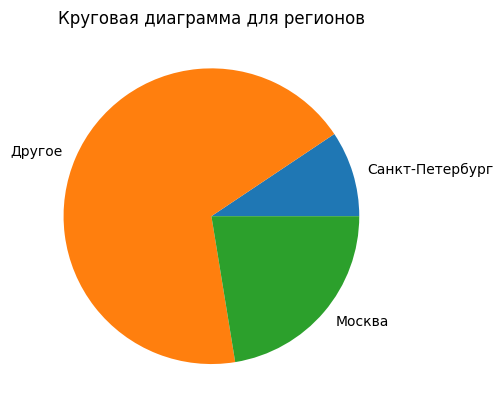

In [485]:
md1 = {city: df['регион'][df['регион'] == city].shape[0] for city in df['регион'].unique()}
plt.pie(md1.values(), labels = md1.keys())
plt.title('Круговая диаграмма для регионов')

In [486]:
df = pd.get_dummies(df, columns = ['регион'], dtype = int, drop_first = True)
df

,опыт работы,возраст,образование,занятость,желаемая з/п,Последнее место работы,пол_Мужчина,регион_Москва,регион_Санкт-Петербург
0,24.0,45.0,0.0,1.50,100000.00,1.0,1,0,1
1,26.0,49.0,1.0,1.50,157869.27,1.0,1,0,0
2,2.0,23.0,0.0,1.50,200000.00,1.0,1,0,0
4,12.0,38.0,1.0,1.50,90000.00,1.0,1,0,0
5,10.0,27.0,0.0,0.75,15000.00,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...
994,10.0,39.0,1.0,1.50,30000.00,0.0,1,0,1
995,4.0,25.0,0.0,1.50,30000.00,1.0,1,0,0
996,10.0,30.0,1.0,2.25,95000.00,0.0,1,1,0
997,13.0,33.0,1.0,1.50,120000.00,1.0,1,1,0


Снова небольшая графа с выводами:
1) Москва -- топ-1 город, где люди ищут работу, что неудивительно, ведь Москва не Россия и как рабочих мест там больше, так и в среднем з/п там выше
2) Петербург здесь стоит на 2 месте, по количеству желающих, опять же по тем же причинам.
3) При этом радует, что Россия большая и бОльшая часть людей хотят остаться в регионах (суммарно естественно)
4) Теперь вспомним про выводы в з/п. Там мы говорили про резкие пики на гистограмме, так вот объясняться это может как раз переходом между регионами.

Теперь можно и на категориальные переменные глянуть. Для них построим столбчатые диаграммы.

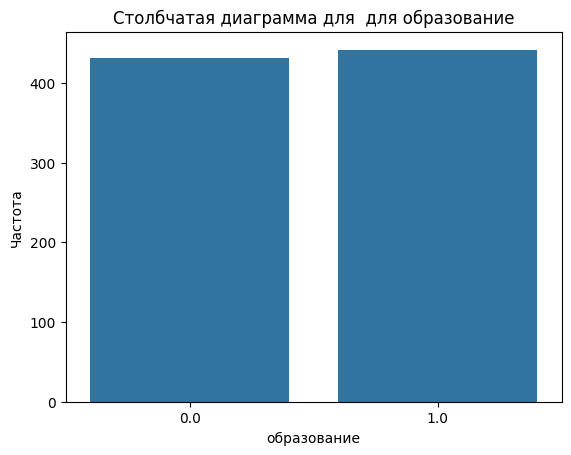

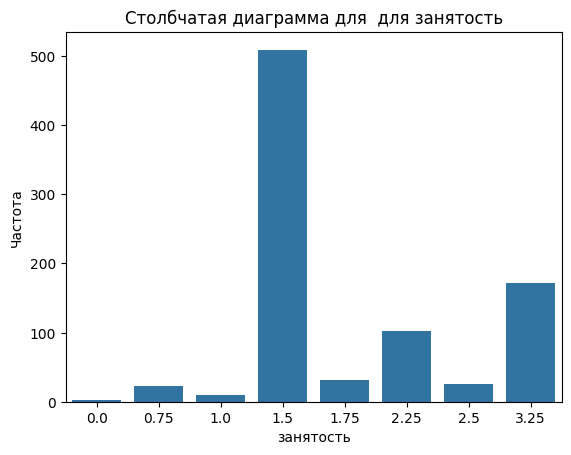

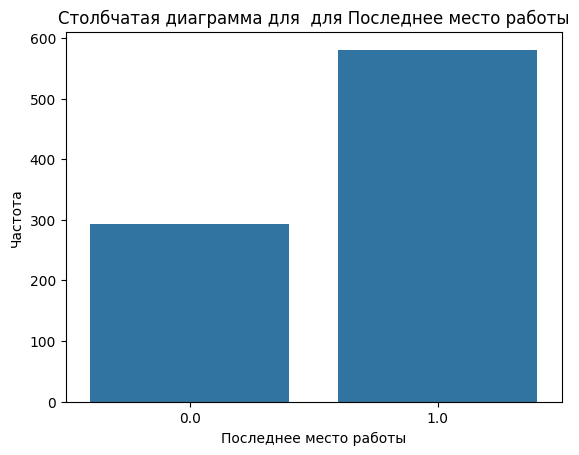

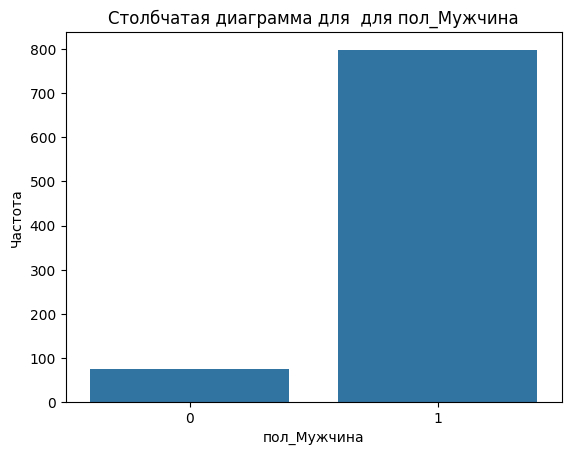

In [487]:
for el in ['образование',	'занятость', 'Последнее место работы',	'пол_Мужчина']:
  sns.countplot(x=el, data=df)
  plt.title('Столбчатая диаграмма для  для '+ el)
  plt.xlabel(el)
  plt.ylabel('Частота')
  plt.show()

И так что можно сказать про наших подопечных:
1) Количество людей с высшим образованием и без примерно одинаковое, что кстати несильно то и удивительно, ведь с ростом популярности различных онлайн курсов, чуть ли не каждый второй захотел стать айтишником с образованием и без.
2) Среди выбранных для исследования людей довольно мало людей, которые готовы работать только не полный день и только над проектами. Большая же часть айтишников готовы рассмотреть для себя различные варианты занятости, однако абсолютное большинство хочет РАБотать фулл дэй и рассматривает только такой вариант. Что ж это не удивительно, ведь большая часть это люди 30+, а они уже куда реже ищут халтурку на пол дня.
3) Также можно заметить, что проектная занятость меньше всего пользуется спросом. Люди предпочитают в своих анкетах ставить полную и частичную занятость. И правильно деды на работе целую смену стояли и ничего, и пятилетки за две недели были.
4) Большая часть людей уже закреплена за каким-то местом работы, но при этом все равно выставляют свои анкеты, хоть их и не сильно больше. Связано это скорее всего с тем, что айтишники постоянно ищут бОльшие зарплаты и за деньги готовы на все (скажем так, у них непрерывная вертикальная мобильность, ведь в разных компаниях на одних и тех должностях з/п может очень сильно отличаться)
5) Мужчин айтишников большинство (опять таки, кто бы сомневался).

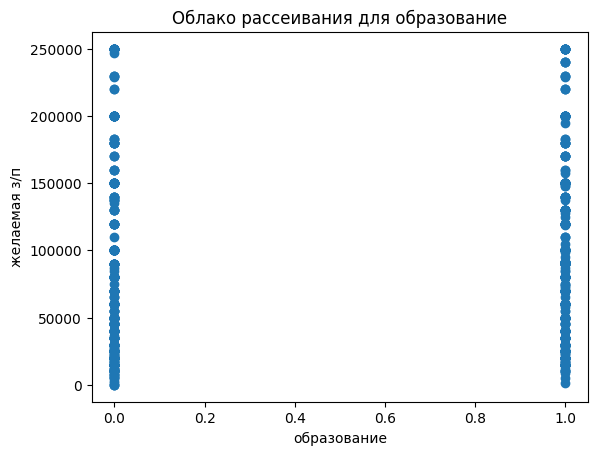

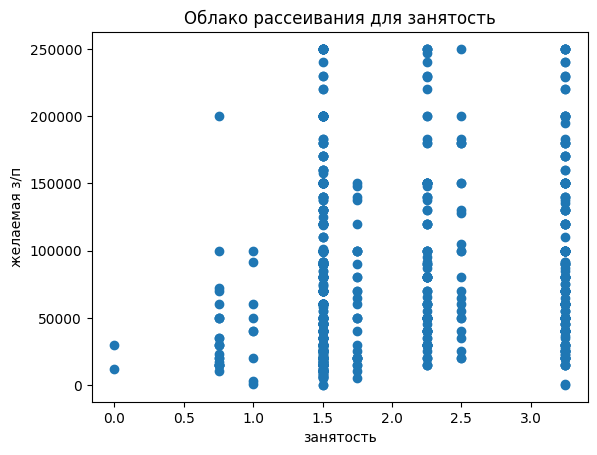

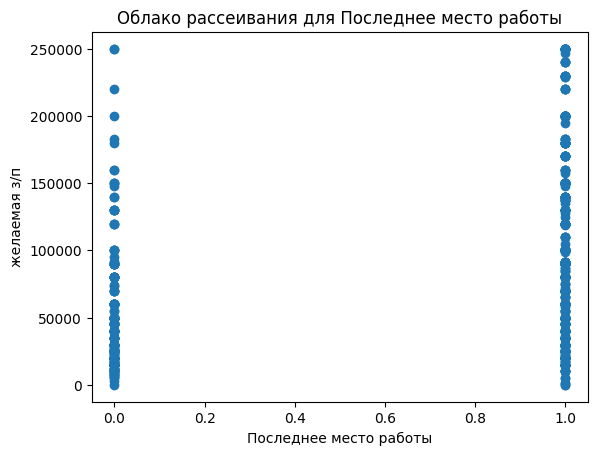

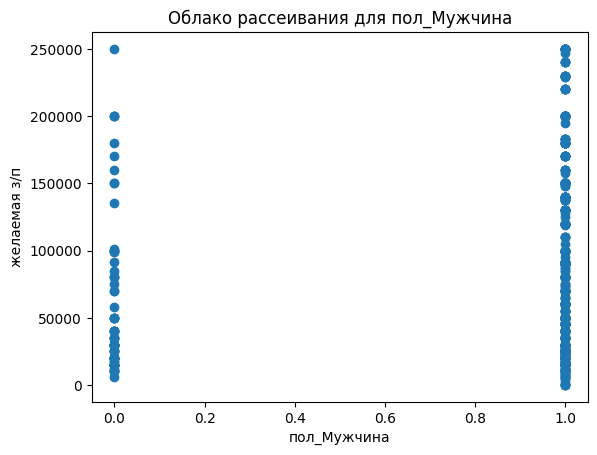

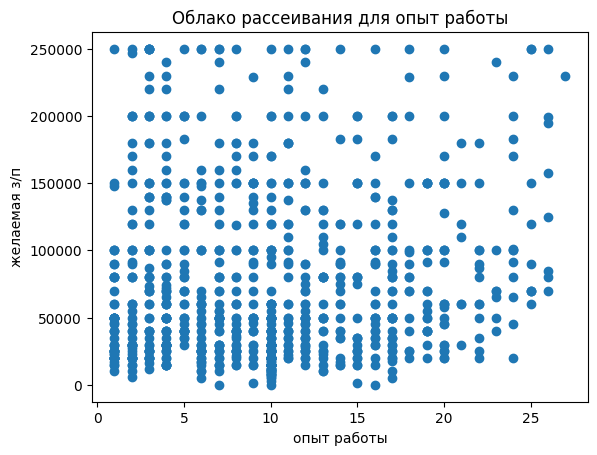

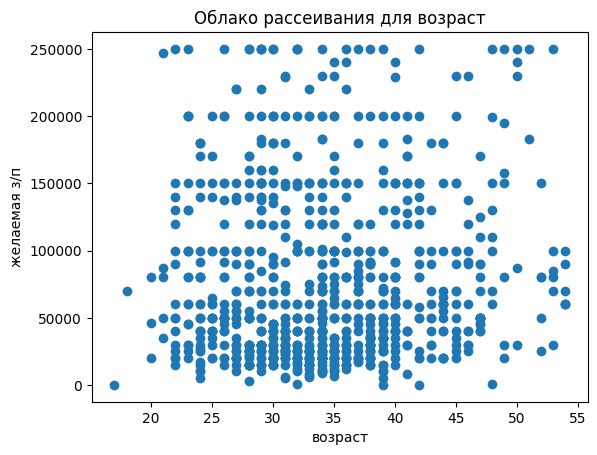

In [488]:
for el in ['образование',	'занятость', 'Последнее место работы',	'пол_Мужчина', 'опыт работы', 'возраст']:
  plt.figure()
  plt.scatter(df[el], df['желаемая з/п'])
  plt.xlabel(el)
  plt.ylabel('желаемая з/п')
  plt.title('Облако рассеивания для ' + el)

Здесь все достаточно грустно. Практически все облака не показывают хорошей взаимосвязи между признаками и объясняемой переменной. Однако ложка меда все таки нашлась:
1) Мужчины чаще требуют более высокую зарплату (ХЫ), но тут это можно скорее объяснить тупо бОльшим количеством мужчин на рынке труда.
2) Ребята и девчонки, которые сейчас работают ставят желаемый уровень з/п выше. Тоже не очень удивительно, ведь они могут борзеть, так как ничего не теряют.
3) Среди образованных людей как-будто-то бы более выский уровень желаемой з/п в среднем.
Про непрерывные признаки особо ничего и не скажешь, там будто просто случайная величина независящая от них. Как вариант это может объясняться разницей внутри регионов.